In [67]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.datasets import make_circles
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.utils import make_forecasting_dataset
from reservoir_computing.datasets import PredLoader
from itertools import product
from scipy.fft import fft
from statsmodels.tsa.seasonal import STL


def fft_analysis(signal):
    
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    
    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    
    return dominant_period, positive_frequencies, magnitudes

def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(10, 8))
    axes[0].plot(original, label='Original')
    axes[0].legend(loc='upper left')
    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].legend(loc='upper left')
    axes[2].plot(decomposition.seasonal, label='Seasonality')
    axes[2].legend(loc='upper left')
    axes[3].plot(decomposition.resid, label='Residuals')
    axes[3].legend(loc='upper left')
    plt.show()

## Exercises

### Exercise 1

- In the MLP example, change the `window_size` ($P$) from 12 to 24. 
- Comment on the results and explain why the performance improve. 

In [ ]:
ts_full = PredLoader().get_data('ElecRome')

# Resample the time series to hourly frequency
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)

# Use only the first 3000 time steps
time_series = ts_hourly[0:3000]
time_steps = np.arange(0, len(time_series))

# Split the time series into training and test sets
train_size = int(0.9*len(time_series))
tr = time_series[:train_size]
te = time_series[train_size:]

def create_windows(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

################ CASE FOR W = 12 ######################

# Define window size and forecast horizon
window_size = 12
forecast_horizon = 24

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

# We are only interested in the last time step of the horizon
y_train = y_train[:, -1]  
y_test = y_test[:, -1] 

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the neural network
mlp = MLPRegressor(hidden_layer_sizes=(16,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for W = 12: {mse:.2f}")

################ CASE FOR W = 24 ######################
# Define window size and forecast horizon
window_size = 24
forecast_horizon = 24

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

# We are only interested in the last time step of the horizon
y_train = y_train[:, -1]  
y_test = y_test[:, -1] 

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the neural network
mlp = MLPRegressor(hidden_layer_sizes=(16,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for W = 24: {mse:.2f}")


Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)
Mean Squared Error for W = 12: 28.26
Mean Squared Error for W = 24: 21.32


The model performance increases for a window of 24 hours since the model is now able to make a prediction with full information of the previous day. Since the data has a seasonality of 24, providing the model with a full season cycle should improve performances.

SIDE NOTE:
- The model performances heavly relies on intialization. without setting any seed, it is not granted that one model performs better than the other.
- This means that the instability of the training has a bigger effect on performances than using a larger window.

### Exercise 2
- In the MLP, change `forecast_horizon` from 24 to 36.
- Do the same change also in the ESN.
- With a forecast horizon of size 24 we used as a baseline the MSE between the time series and its shifted version by 24 lags, `mse = mean_squared_error(y_test[24:], y_test[:-24])`. Is this a good baseline also when the forecast horizon changes? What could be a better baseline?


(241,)
Mean Squared Error for forecast horizon = 36: 39.02


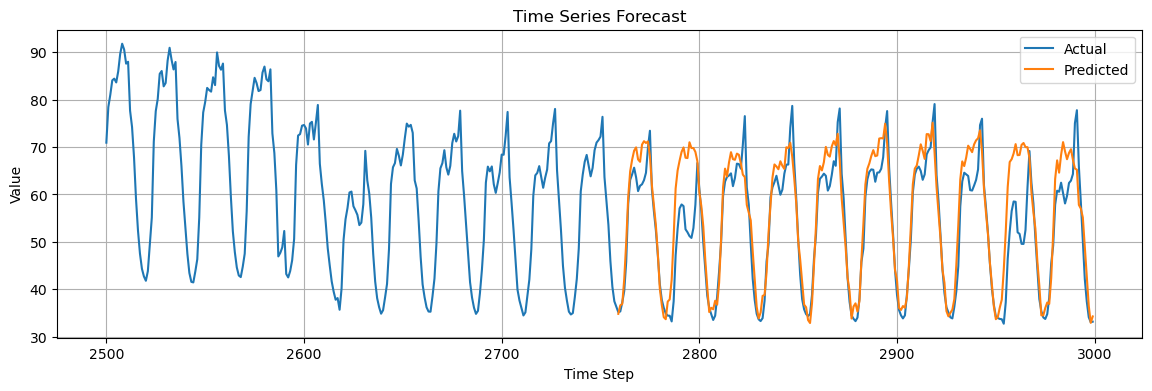

In [19]:
# Define window size and forecast horizon
window_size = 24
forecast_horizon = 36

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

# We are only interested in the last time step of the horizon
y_train = y_train[:, -1]  
y_test = y_test[:, -1] 

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the neural network
mlp = MLPRegressor(hidden_layer_sizes=(16,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test_scaled)
print((y_pred.shape))
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error for forecast horizon = 36: {mse:.2f}")
plt.figure(figsize=(14, 4))
plt.plot(time_steps[2500:], time_series[2500:], label="Actual")
plt.plot(time_steps[-len(y_test):], y_pred, label="Predicted")
plt.title("Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

states_tr shape: (1, 2631, 900)
states_te shape: (1, 231, 900)
Training time: 0.0499s
Test time: 0.0005s
Mean Squared Error: 59.79


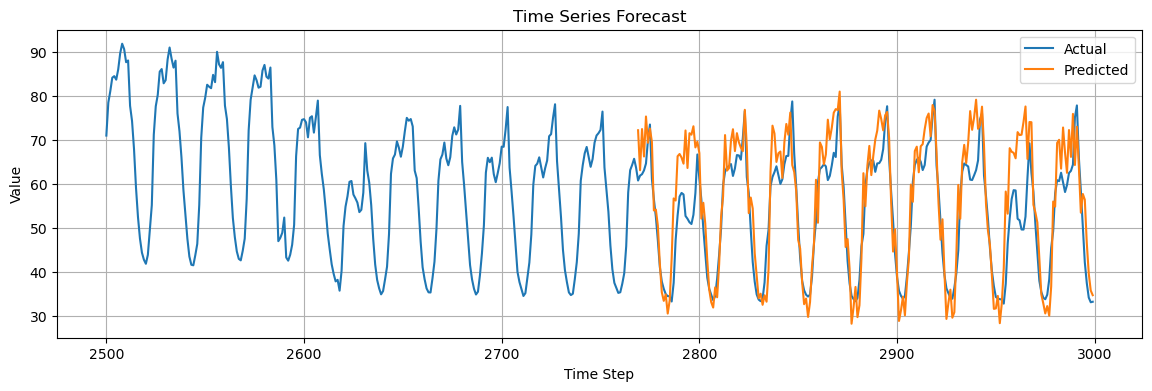

In [ ]:
res= Reservoir(n_internal_units=900,
               spectral_radius=0.99,
               input_scaling=0.1,
               connectivity=0.25)

n_drop=10
states_tr = res.get_states(X_train[None,:,:], n_drop=n_drop, bidir=False)
states_te = res.get_states(X_test[None,:,:], n_drop=n_drop, bidir=False)
print(f"states_tr shape: {states_tr.shape}\nstates_te shape: {states_te.shape}")

# Fit the ridge regression model
ridge = Ridge(alpha=1.0) 
ridge.fit(states_tr[0], y_train[n_drop:])

# Compute the predictions
Yhat = ridge.predict(states_te[0])

mse = mean_squared_error(Yhat, y_test[n_drop:])
print(f"Mean Squared Error: {mse:.2f}")

plt.figure(figsize=(14, 4))
plt.plot(time_steps[2500:], time_series[2500:], label="Actual")
plt.plot(time_steps[-len(y_test[n_drop:]):], Yhat, label="Predicted")
plt.title("Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid()
plt.legend()

Using a baseline of 24 h checks if the model (that in the example was trained with a window of 12) performs better than just using the previous day as prediction.

The baseline depends on the seasonality of the data, that is 24 h regardless the forecast horizon.

CHIEDERE A SARA

### Exercise 3

Contrarily from model-based approach such as ARIMA, the MLP and the ESN do not strctly require the data to be stationary. However, by removing trend and seasonality the MLP and the ESN can focus only on predicting the residuals.

- Remove trend and seasonality and train both MLP and ESN to train the residuals. 
- In testing, remember to put back the trend and seasonality when computing the predictions.
- Compare the results with those obtained by training the MLP and the ESN on the original data.

First identify the main seasonal coponent using FFT (we will assume 24h is the seasonality in this case, no need for FFT), then remove trend and seasonality using STL.

I will also assume a forecast horizon of 24 and window of 12.

Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)


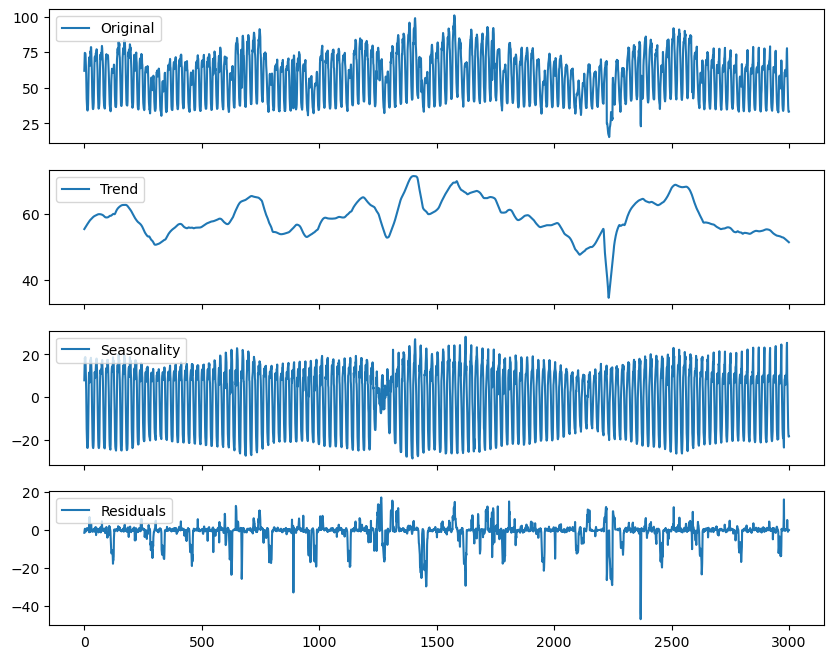

In [59]:
ts_full = PredLoader().get_data('ElecRome')

# Resample the time series to hourly frequency
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)

# Use only the first 3000 time steps
time_series = ts_hourly[0:3000]
time_steps = np.arange(0, len(time_series))

decomposed_ts = STL(endog=time_series, period=24, robust=True).fit()

seas_decomp_plots(time_series, decomposed_ts)



Now prepare and split the dataset and train MPL and reservoir.

In [45]:
# Split the time series into training and test sets
train_size = int(0.9*len(decomposed_ts.resid))
tr = decomposed_ts.resid[:train_size]
te = decomposed_ts.resid[train_size:]

def create_windows(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

################ CASE FOR W = 12 ######################

# Define window size and forecast horizon
window_size = 12
forecast_horizon = 24

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

# We are only interested in the last time step of the horizon
y_train = y_train[:, -1]  
y_test = y_test[:, -1] 

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train MLP only on residuals, then put back trend and seasonality only for performance evaluation.

c:\Users\Francesco\.conda\envs\time_series\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


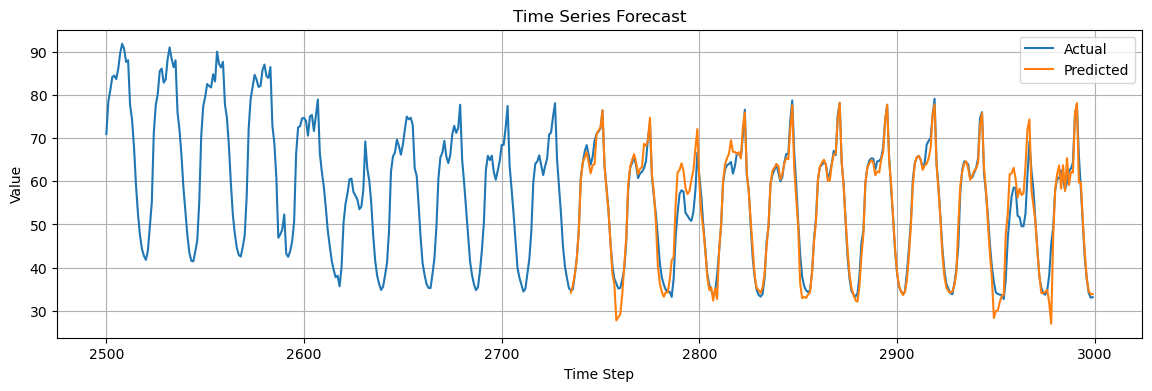

Mean Squared Error for W = 12: 10.96


In [52]:
# Define window size and forecast horizon
window_size = 12
forecast_horizon = 24

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

# We are only interested in the last time step of the horizon
y_train = y_train[:, -1]  
y_test = y_test[:, -1] 

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the neural network
mlp = MLPRegressor(hidden_layer_sizes=(16,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_resid = mlp.predict(X_test_scaled)


#### ADD TREND AND SEASONALITY BACK ####
y_pred = y_pred_resid + decomposed_ts.trend[-len(y_test):] + decomposed_ts.seasonal[-len(y_test):]

plt.figure(figsize=(14, 4))
plt.plot(time_steps[2500:], time_series[2500:], label="Actual")
plt.plot(time_steps[-len(y_test):], y_pred, label="Predicted")
plt.title("Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()


mse = mean_squared_error(time_series[-len(y_test):], y_pred)
print(f"Mean Squared Error for W = 12: {mse:.2f}")

Train Reservoir only on residuals, then put back trend and seasonality only for performance evaluation.

Mean Squared Error: 15.07


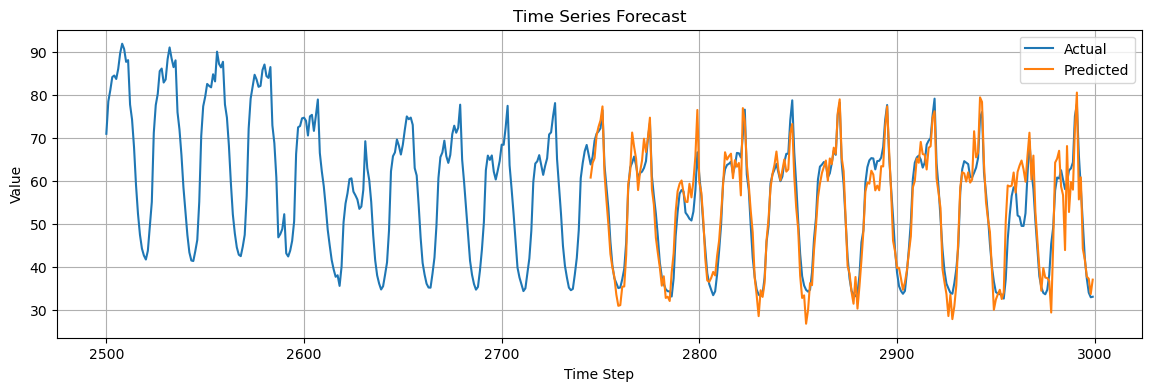

In [58]:
res= Reservoir(n_internal_units=900,
               spectral_radius=0.99,
               input_scaling=0.1,
               connectivity=0.25)

n_drop=10
states_tr = res.get_states(X_train[None,:,:], n_drop=n_drop, bidir=False)
states_te = res.get_states(X_test[None,:,:], n_drop=n_drop, bidir=False)

# Fit the ridge regression model
ridge = Ridge(alpha=1.0) 
ridge.fit(states_tr[0], y_train[n_drop:])

# Compute the predictions
Yhat_resid = ridge.predict(states_te[0])

# Add trend and seasonality back
Yhat = Yhat_resid + decomposed_ts.trend[-len(y_test[n_drop:]):] + decomposed_ts.seasonal[-len(y_test[n_drop:]):]

print(f"Mean Squared Error: {mse:.2f}")

plt.figure(figsize=(14, 4))
plt.plot(time_steps[2500:], time_series[2500:], label="Actual")
plt.plot(time_steps[-len(y_test[n_drop:]):], Yhat, label="Predicted")
plt.title("Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid()
plt.legend()


mse = mean_squared_error(time_series[-len(y_test[n_drop:]):], Yhat)


The performances of training both models on residuals only got better in both cases. This is because seasonality and trend are confounding factors for the prediction.

Essentially, removing trend and seasonality can be considered "preprocessing" (like normalizing data before training) which enables the model to focus only on the non preditable part of the time series.

### Exercise 4

For this exercise, we will consider a new dataset consisting of hourly water temperatures from Gulf of Mexico near Key West, Florida. 
The hourly temperatures are provided from October 3, 2016 to October 3, 2017
The dataset consists of a data frame with 6572 observations on the following 3 variables.

- `DateTime` Date and time of reading (format mm/dd/yyyy h:00).
- `WaterTemp`: Water temperature (in degrees Fahrenheit).
- `t`: Time index (1 to 673).

Raw data:
------------------
          DateTime  WaterTemp  t
0  10/3/2016 0:00       86.2  1
1  10/3/2016 1:00       86.2  2
2  10/3/2016 2:00       86.2  3
3  10/3/2016 3:00       86.2  4
4  10/3/2016 4:00       86.0  5


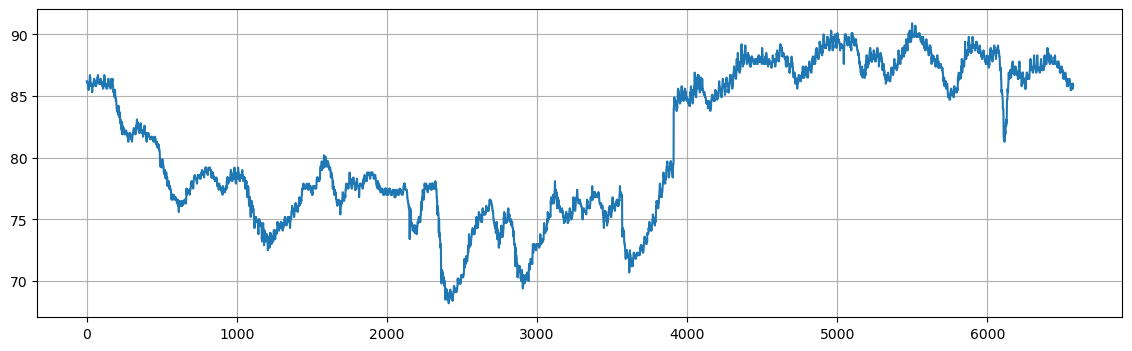

In [60]:
temps = sm.datasets.get_rdataset("KeyWestWater", "Stat2Data").data
print("Raw data:\n------------------\n", temps.head())
plt.figure(figsize=(14,4))
plt.plot(temps["WaterTemp"])
plt.grid()
plt.show()

- Apply the MLP on the temperature data.
- Perform a small grid search to try different values for the following hyperparameters:
    - `hidden_layer_sizes` (e.g., try more layers `[16, 16, 8]`, layers with more units `[32, 16]`, etc...).
    - `learning_rate_init`.
    - `activation` (try at least `tanh` and `relu`).

Since the data is made by daily measirements, it will probably have a seasonality of 24h. Let's prepare the data with a split og 80/10/10 to perform hyperparameter selection on the validation set:


In [72]:
# Split the time series into training and test sets
# Split the time series into training and test sets
train_size = int(0.8*len(temps["WaterTemp"]))
val_size = int(0.1*len(temps["WaterTemp"]))
test_size = val_size
tr = temps["WaterTemp"][:train_size]
val = temps["WaterTemp"][train_size:val_size+train_size]
te = temps["WaterTemp"][val_size+train_size:]

def create_windows(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)


################ CASE FOR W = 12 ######################

# Define window size and forecast horizon
window_size = 12
forecast_horizon = 24

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_val, y_val = create_windows(val, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# We are only interested in the last time step of the horizon
y_train = y_train[:, -1]  
y_val = y_val[:, -1]
y_test = y_test[:, -1] 

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train shape: (5222, 12), y_train shape: (5222, 24)
X_val shape: (622, 12), y_val shape: (622, 24)
X_test shape: (623, 12), y_test shape: (623, 24)


We will now try to apply MLP with a window of 12 and a forecast horizon of 24 with different hyperparameters:
1) Change hidden layers:
- [32, 16 ,8]
- [64, 32]
- [16, 32, 32, 16]
2) Change LR:
- 0.01
- 0.001 (default)
- 0.0001
3) Change activation:
- tanh
- ReLU
- sigmoid

And select the best combination on the validation set. Then, we will test on the test set only the best combination.

In [ ]:
# Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define hyperparameter grid
hidden_layer_options = [
    (32, 16, 8),
    (64, 32),
    (16, 32, 32, 16)
]
learning_rates = [0.01, 0.001, 0.0001]
activations = ['tanh', 'relu', 'logistic'] 

results = []

# Grid search
for layers, lr, activation in product(hidden_layer_options, learning_rates, activations):
    mlp = MLPRegressor(
        hidden_layer_sizes=layers,
        activation=activation,
        solver='adam',
        learning_rate_init=lr,
        max_iter=1000,
    )
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    
    results.append({
        'layers': layers,
        'lr': lr,
        'activation': activation,
        'val_mse': mse
    })
    print(f"Tested {layers}, lr={lr}, activation={activation} → MSE: {mse:.4f}")

Tested (32, 16, 8), lr=0.01, activation=tanh → MSE: 73.6835
Tested (32, 16, 8), lr=0.01, activation=relu → MSE: 2.1617
Tested (32, 16, 8), lr=0.01, activation=logistic → MSE: 0.5873
Tested (32, 16, 8), lr=0.001, activation=tanh → MSE: 73.8168
Tested (32, 16, 8), lr=0.001, activation=relu → MSE: 0.7970
Tested (32, 16, 8), lr=0.001, activation=logistic → MSE: 0.5977


c:\Users\Francesco\.conda\envs\time_series\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Tested (32, 16, 8), lr=0.0001, activation=tanh → MSE: 3562.6955
Tested (32, 16, 8), lr=0.0001, activation=relu → MSE: 0.5868


c:\Users\Francesco\.conda\envs\time_series\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Tested (32, 16, 8), lr=0.0001, activation=logistic → MSE: 4007.5776
Tested (64, 32), lr=0.01, activation=tanh → MSE: 73.8262
Tested (64, 32), lr=0.01, activation=relu → MSE: 0.6928
Tested (64, 32), lr=0.01, activation=logistic → MSE: 0.5710
Tested (64, 32), lr=0.001, activation=tanh → MSE: 0.5355
Tested (64, 32), lr=0.001, activation=relu → MSE: 0.4961
Tested (64, 32), lr=0.001, activation=logistic → MSE: 0.5322


c:\Users\Francesco\.conda\envs\time_series\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Tested (64, 32), lr=0.0001, activation=tanh → MSE: 17.6353
Tested (64, 32), lr=0.0001, activation=relu → MSE: 0.4901


c:\Users\Francesco\.conda\envs\time_series\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Tested (64, 32), lr=0.0001, activation=logistic → MSE: 83.5848
Tested (16, 32, 32, 16), lr=0.01, activation=tanh → MSE: 0.8008
Tested (16, 32, 32, 16), lr=0.01, activation=relu → MSE: 0.4582
Tested (16, 32, 32, 16), lr=0.01, activation=logistic → MSE: 73.3914
Tested (16, 32, 32, 16), lr=0.001, activation=tanh → MSE: 73.3930
Tested (16, 32, 32, 16), lr=0.001, activation=relu → MSE: 0.6051
Tested (16, 32, 32, 16), lr=0.001, activation=logistic → MSE: 73.6904


c:\Users\Francesco\.conda\envs\time_series\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Tested (16, 32, 32, 16), lr=0.0001, activation=tanh → MSE: 1445.8724
Tested (16, 32, 32, 16), lr=0.0001, activation=relu → MSE: 0.6829
Tested (16, 32, 32, 16), lr=0.0001, activation=logistic → MSE: 2180.7690


c:\Users\Francesco\.conda\envs\time_series\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [69]:
# Sort results by MSE
results_sorted = sorted(results, key=lambda x: x['val_mse'])

# Best config
best = results_sorted[0]
print("\nBest configuration:")
print(best)


Best configuration:
{'layers': (16, 32, 32, 16), 'lr': 0.01, 'activation': 'relu', 'val_mse': 0.458249095729732}


Now let's test on the test set this parameter set configuration, after training it again

Mean Squared Error for best model: 2.39


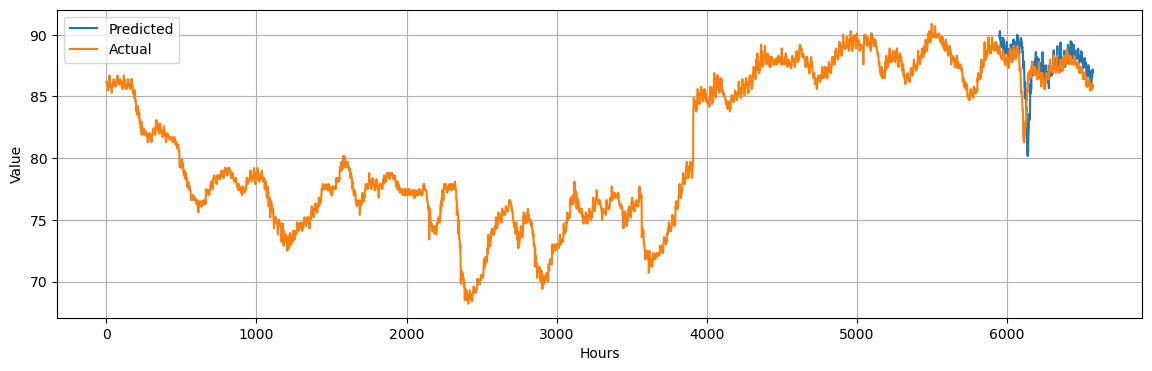

In [ ]:

final_model = MLPRegressor(
    hidden_layer_sizes=best['layers'],
    activation=best['activation'],
    solver='adam',
    learning_rate_init=best['lr'],
    max_iter=1000,
)
final_model.fit(X_train_scaled, y_train)

# Predict on test set
y_test_pred = final_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error for best model: {mse:.2f}")

plt.figure(figsize=(14, 4))
plt.plot(temps["WaterTemp"].index[-len(y_test):], y_test_pred, label="Predicted")
plt.plot(temps["WaterTemp"],  label="Actual")
plt.xlabel("Hours")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()


- Apply the ESN on the temperature data.
- Perform a small grid search to try different values for the following hyperparameters:
    - `spectral_radius`.
    - `input_scaling`.
    - `n_internal_units`.
    - `connectivity`.

Let's use the same dataset split of previous exercise. The hyperparameter grid wil be the following:
1) Change spectral radius, trye two values slightly below 1 and one value over 1:
- 0.95
- 0.99
- 1.01
2) Change input scaling:
- 0.1
- 0.3
3) Change number of internal units:
- 600
- 900
- 1500
4) Change connectivity (stayng around 0.2/0.3):
- 0.15
- 0.25
- 0.35

To speed up the analisys, also use PCA to lower the nuber of states.

In [ ]:
# Define hyperparameter grid
spectral_radius_list = [0.93, 0.99, 1.05]
input_scaling_list = [0.1, 0.3]
n_internal_units_list = [900, 1700, 500] 
connectivity_list = [0.15, 0.25, 0.35]

results = []

# Grid search
for sp_rad, in_scaling, n_units, conn in product(spectral_radius_list, input_scaling_list, n_internal_units_list, connectivity_list):

    res= Reservoir(n_internal_units=n_units,
                spectral_radius=sp_rad,
                input_scaling=in_scaling,
                connectivity=conn)

    n_drop=10
    states_tr = res.get_states(X_train_scaled[None,:,:], n_drop=n_drop, bidir=False)
    states_val = res.get_states(X_val_scaled[None,:,:], n_drop=n_drop, bidir=False)

    # Perform PCA on the training data
    pca = PCA(n_components=75)
    states_tr_pca = pca.fit_transform(states_tr[0])
    states_tr_pca = np.expand_dims(states_tr_pca, axis=0)
    states_val_pca = pca.transform(states_val[0])
    states_val_pca = np.expand_dims(states_val_pca, axis=0)

    # Fit the ridge regression model
    ridge = Ridge(alpha=1.0) 
    ridge.fit(states_tr_pca[0], y_train[n_drop:])

    # Compute the predictions
    curr_preds = ridge.predict(states_val_pca[0])

    mse = mean_squared_error(curr_preds, y_val[n_drop:])
    results.append({
        'spectral_radius': sp_rad,
        'input_scaling': in_scaling,
        'n_internal_units': n_units,
        'connectivity': conn,
        'val_mse': mse
    })
    print(f"Spectral radius={sp_rad}, input scaling={in_scaling}, internal unit number={n_units}, connectivity={conn} → MSE: {mse:.4f}")

Spectral radius=0.93, input scaling=0.1, internal unit number=900, connectivity=0.15 → MSE: 0.4066
Spectral radius=0.93, input scaling=0.1, internal unit number=900, connectivity=0.25 → MSE: 0.4115
Spectral radius=0.93, input scaling=0.1, internal unit number=900, connectivity=0.35 → MSE: 0.4192
Spectral radius=0.93, input scaling=0.1, internal unit number=1700, connectivity=0.15 → MSE: 0.4123
Spectral radius=0.93, input scaling=0.1, internal unit number=1700, connectivity=0.25 → MSE: 0.4114
Spectral radius=0.93, input scaling=0.1, internal unit number=1700, connectivity=0.35 → MSE: 0.4026
Spectral radius=0.93, input scaling=0.1, internal unit number=500, connectivity=0.15 → MSE: 0.4114
Spectral radius=0.93, input scaling=0.1, internal unit number=500, connectivity=0.25 → MSE: 0.4173
Spectral radius=0.93, input scaling=0.1, internal unit number=500, connectivity=0.35 → MSE: 0.4241
Spectral radius=0.93, input scaling=0.3, internal unit number=900, connectivity=0.15 → MSE: 0.4479
Spectra

All models have more or less the same MSE. A good option couldbe to add the number of PCA selected to be a hyperparameter as well.

Let's now test the best model on the test set:

In [99]:
# Sort results by MSE
results_sorted = sorted(results, key=lambda x: x['val_mse'])

# Best config
best = results_sorted[0]
print("\nBest configuration:")
print(best)


Best configuration:
{'spectral_radius': 1.01, 'input_scaling': 0.1, 'n_internal_units': 600, 'connectivity': 0.25, 'val_mse': 0.3996613642465513}


Mean Squared Error for best model: 2.03


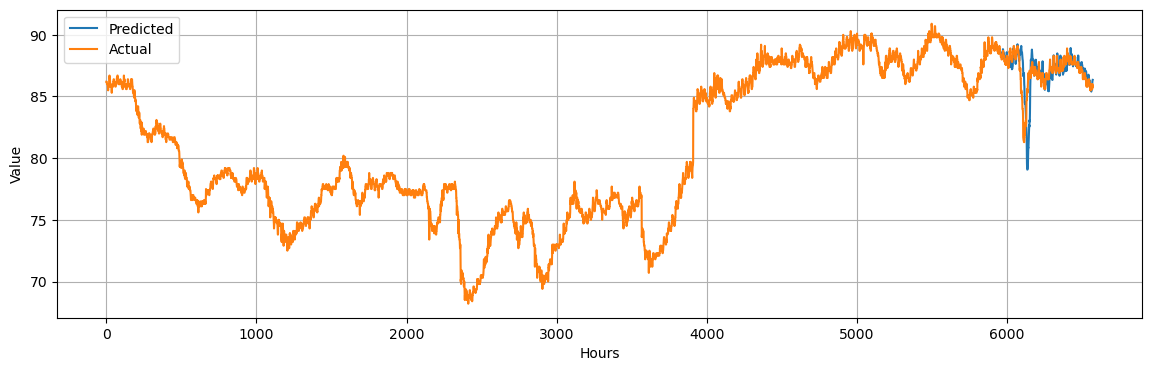

In [102]:
res= Reservoir(n_internal_units=best['n_internal_units'],
            spectral_radius=best['spectral_radius'],
            input_scaling=best['input_scaling'],
            connectivity=best['connectivity'])

n_drop=10
states_tr = res.get_states(X_train_scaled[None,:,:], n_drop=n_drop, bidir=False)
states_ts = res.get_states(X_test_scaled[None,:,:], n_drop=n_drop, bidir=False)

# Perform PCA on the training data
pca = PCA(n_components=75)
states_tr_pca = pca.fit_transform(states_tr[0])
states_tr_pca = np.expand_dims(states_tr_pca, axis=0)
states_ts_pca = pca.transform(states_ts[0])
states_ts_pca = np.expand_dims(states_ts_pca, axis=0)

# Fit the ridge regression model
ridge = Ridge(alpha=1.0) 
ridge.fit(states_tr_pca[0], y_train[n_drop:])

# Compute the predictions
test_preds = ridge.predict(states_ts_pca[0])

mse = mean_squared_error(test_preds, y_test[n_drop:])
print(f"Mean Squared Error for best model: {mse:.2f}")
plt.figure(figsize=(14, 4))
plt.plot(temps["WaterTemp"].index[-len(y_test) + n_drop:], test_preds, label="Predicted")
plt.plot(temps["WaterTemp"],  label="Actual")
plt.xlabel("Hours")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()
